In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Eventually, for Anaconda warnings.
# Can be commented out.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
# Load basic libraries
import seaborn; seaborn.set()
import pickle, copy
import numpy as np
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn_crfsuite import scorers, metrics, CRF

In [ ]:
import json
data = json.load(open('data/annotated_dataset.json'))
print(len(data))

In [ ]:
data[10]

Tag consolidation to remove unfrequently used tags

In [4]:
# Specific Tag consolidation: decide here which tags to keep for level 1 parsing
correspondances = {
    'abbreviatedtitle': 'title', #
    'abbreviation': 'abbreviation', 
    'appendix': 'ref', #
    'archivalfond': 'archivalreference', #
    'archivalreference': 'archivalreference',
    'archivalseries': 'archivalreference', #
    'archivalunit': 'archivalreference', #
    'archive': 'archive_lib', #
    'attachment': 'attachment',
    'author': 'author',
    'box': 'box',
    'cartulation': 'cartulation', 
    'cedola': 'ref', #
    'century': 'date', #
    'chapter': 'ref', #
    'citation': 'ref', #
    'codex': 'archivalreference', #
    'column': 'column',
    'conjunction': 'conjunction', 
    'curator': 'author', #
    'date': 'date', 
    'editor': 'author', #
    'fascicolo': 'folder', #
    'filza': 'filza',
    'folder': 'folder',
    'foliation': 'foliation',
    'fond': 'archivalreference', #
    'implicit': '',
    'library': 'archive_lib', #
    'mazzo': 'ref', #
    'notary': 'archivalreference', #
    'note': 'numbered_ref', #
    'numbering': 'numbered_ref', #
    'other': '', #
    'pagination': 'pagination',
    'parchment': 'ref', #
    'period': 'date', #
    'protocollo': 'ref', #
    'parte': 'ref', #
    'publicationnumber': 'publicationnumber-year', #
    'publicationnumber-year': 'publicationnumber-year',
    'publicationplace': 'publicationplace',
    'publicationspecifications': 'publicationspecifications',
    'publicationyear': 'year', #
    'publisher': 'publisher',
    'registry': 'registry',
    'responsible': 'author', #
    'series': 'series',
    'table': 'ref', #
    'title': 'title',
    'tomo': 'tomo',
    'topicdate': 'publicationplace', #
    'voce': 'ref', #
    'volume': 'volume',
    'website': 'ref', #
    'year': 'year',
    '': ''
}

# define supporting functions
window = 2 # the window of dependance for the CRFs: use plus and minus that number as a context
from feature_extraction_words import word2features, generate_featuresLight
def text2features(text):
    return [word2features(text, i, window = window) for i in range(len(text))]
def text2featuresL(text):
    return [word2features(text, i, window = window, feature_function=generate_featuresLight) for i in range(len(text))]

# create beginend tags Y
def text2labelsBE(text):
    return [token[2][2] for token in text]

# create tagged-beginend tags Y
def text2labelsTBE(text):
    return [token[2][3] for token in text]

# create specific tags Y
def text2labelsS(text):
    return [correspondances[token[2][1]] for token in text]

In [5]:
# prepare annotated data for CRF
annotated_data = list()
for doc in data:
    doc_data_ann = list()
    for page in doc["pages"].values():
        if page["is_annotated"]:
            doc_data_ann.extend(page["offsets"])
    if len(doc_data_ann) > 0:
        annotated_data.append(doc_data_ann)
print(len(annotated_data))
print(len(data))

340
1377


In [6]:
%%time
# Define train and test sets
from sklearn.model_selection import train_test_split
d = [text2features(text) for text in annotated_data]
l = [text2labelsS(text) for text in annotated_data]
l_tbe = [text2labelsTBE(text) for text in annotated_data]
# Clean tag space
labels_to_keep = list(set([x for y in l for x in y]))
labels_to_keep_tbe = list(set([x for y in l_tbe for x in y]))

"""
# see: http://stackoverflow.com/questions/34275475/python-sci-kit-learn-multilabel-classification-valueerror-could-not-convert-s
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
l = MultiLabelBinarizer().fit_transform(l)      
dv = DictVectorizer(sparse=False)
#cv.fit_transform(col1) 
#<4x4 sparse matrix of type '<class 'numpy.int64'>'
#   with 10 stored elements in Compressed Sparse Row format>
d = dv.fit_transform(d).toarray()
"""

random_state = np.random.RandomState(0)
    
# VALIDATION set
X_rest, X_valid, y_rest, y_valid = train_test_split(d, l, test_size=0.1, random_state=random_state)
# TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, test_size=0.25, random_state=random_state)

CPU times: user 2min 47s, sys: 5.7 s, total: 2min 52s
Wall time: 2min 52s


In [21]:
# Count labels
counts = {x:0 for x in labels_to_keep}
for c in counts.keys():
    counts[c] = len([x for y in l for x in y if x==c])
print(counts)
counts = {x:0 for x in labels_to_keep_tbe}
for c in counts.keys():
    counts[c] = len([x for y in l_tbe for x in y if x==c])
print(counts)

{'': 113163, 'tomo': 1446, 'archive_lib': 7860, 'foliation': 3334, 'numbered_ref': 8420, 'cartulation': 6116, 'publisher': 8596, 'publicationnumber-year': 6997, 'date': 10085, 'year': 15283, 'title': 205516, 'conjunction': 3119, 'series': 1079, 'publicationspecifications': 6480, 'archivalreference': 21358, 'folder': 1794, 'box': 3000, 'abbreviation': 6412, 'volume': 7297, 'ref': 2153, 'author': 55898, 'registry': 2957, 'pagination': 34097, 'column': 751, 'attachment': 6614, 'publicationplace': 13917, 'filza': 986}
{'b-primary-full': 4030, 'e-meta-annotation': 6544, 'e-primary-full': 4046, 'i-secondary-full': 136385, 'i-secondary-partial': 49388, 'b-secondary-partial': 9841, 'i-meta-annotation': 131803, 'e-secondary-partial': 9944, 'i-primary-partial': 18678, 'b-primary-partial': 3507, 'b-secondary-full': 10620, 'i-primary-full': 39862, 'b-meta-annotation': 6509, 'e-primary-partial': 3584, 'o': 109240, 'e-secondary-full': 10747}


In [ ]:
# An example use of CRFs
crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels_to_keep, digits=3
))

In [27]:
%%time
# Parameters search
crf = sklearn_crfsuite.CRF( 
    max_iterations=100,
    algorithm = 'lbfgs',
    all_possible_transitions=False
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05)
}

from sklearn.metrics import make_scorer
from support_functions import BER
scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels_to_keep)
#scorer = make_scorer(BER, greater_is_better=True)
    
# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-15, 
                        n_iter=5, 
                        scoring=scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-15)]: Done  12 out of  15 | elapsed: 29.3min remaining:  7.3min
[Parallel(n_jobs=-15)]: Done  15 out of  15 | elapsed: 29.6min finished


CPU times: user 31min 54s, sys: 2min 47s, total: 34min 42s
Wall time: 56min 38s


In [28]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

best params: {'c2': 0.067592883332507694, 'c1': 0.37774963191685329}
best CV score: 0.817459582953


Dark blue => 0.8139, dark red => 0.8175


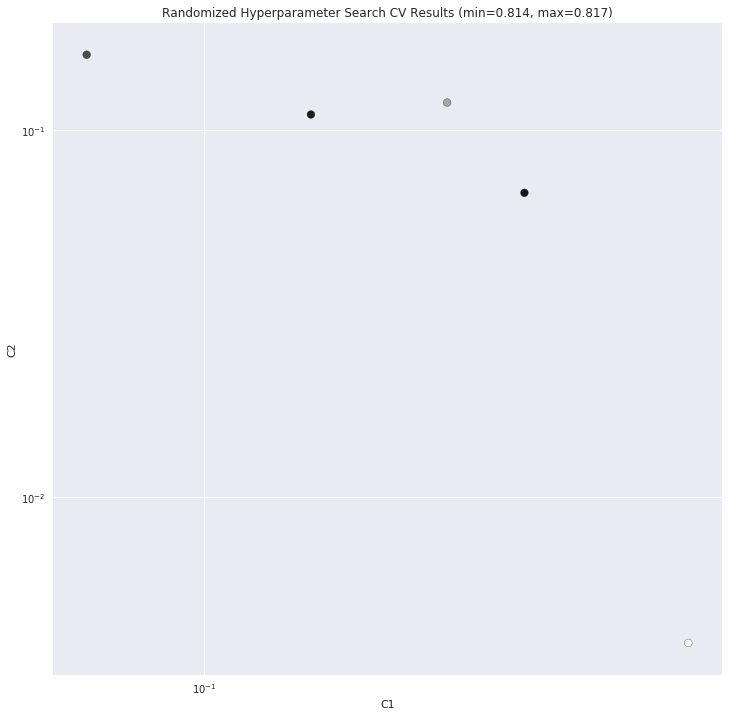

In [29]:
# Explore paramether space
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

                           precision    recall  f1-score   support

                               0.778     0.856     0.815     23144
                     tomo      0.660     0.445     0.532       440
              archive_lib      0.910     0.744     0.818      2095
                foliation      0.927     0.878     0.902       706
             numbered_ref      0.594     0.590     0.592      1799
                      box      0.587     0.728     0.650       942
                publisher      0.876     0.698     0.777      2397
                     date      0.804     0.773     0.788      2790
                   series      0.715     0.772     0.742       237
                   folder      0.535     0.244     0.335       726
                   volume      0.699     0.448     0.546      2007
                   author      0.893     0.865     0.879     13543
                   column      0.500     0.486     0.493        70
              cartulation      0.955     0.891     0.922     

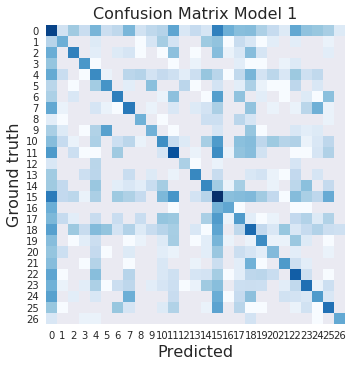

In [30]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels_to_keep, digits=3
))
# Confusion matrices
from sklearn.metrics import confusion_matrix
from support_functions import flatten_predictions

print(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep))
plt.imshow(np.log(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep)),
           cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.ylabel('Ground truth', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.xticks(np.arange(0, len(labels_to_keep), 1))
plt.yticks(np.arange(0, len(labels_to_keep), 1))
plt.title("Confusion Matrix Model 1", fontsize=16)
plt.savefig("plots/conf_M1_ALL.pdf")
#M = np.argsort(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep), axis=1)
#print(M[:,-5:])

In [32]:
# K-fold validation
from sklearn.model_selection import cross_val_score
from support_functions import BER
from sklearn.metrics import make_scorer
scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels_to_keep)
# use balanced error rate if all tags are equally important. Usually, this is not the case.
scorer2 = make_scorer(BER, greater_is_better=True)

# plug here your params, or use rs.best_params_
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2= 0.067592883332507694, c1= 0.37774963191685329,
    max_iterations=200, 
    all_possible_transitions=True
)
k = 5

cv = cross_val_score(crf, X_rest, y_rest, cv=k, scoring=scorer, n_jobs=-2)
print("%d-fold validation mean: "%k,cv.mean())
#cv = cross_val_score(crf, X_rest, y_rest, cv=k, scoring=scorer2, n_jobs=-2)
#print("%d-fold validation mean: "%k,cv.mean())

5-fold validation mean:  0.834504393337


JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f2ccb637660, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/root/anaconda3/envs/lb_main_analysis/lib/python...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/root/anacon.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f2ccb637660, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/root/anaconda3/envs/lb_main_analysis/lib/python...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/root/anacon.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 5, 10, 12, 47, 23, 889293, tzinfo=datetime.timezone.utc), 'msg_id': '196FA3936CF94E5A8A9BC69E59541707', 'msg_type': 'execute_request', 'session': '73487671F46443C786512FD7BCC9E5B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '196FA3936CF94E5A8A9BC69E59541707', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'73487671F46443C786512FD7BCC9E5B1']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 5, 10, 12, 47, 23, 889293, tzinfo=datetime.timezone.utc), 'msg_id': '196FA3936CF94E5A8A9BC69E59541707', 'msg_type': 'execute_request', 'session': '73487671F46443C786512FD7BCC9E5B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '196FA3936CF94E5A8A9BC69E59541707', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'73487671F46443C786512FD7BCC9E5B1'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 5, 10, 12, 47, 23, 889293, tzinfo=datetime.timezone.utc), 'msg_id': '196FA3936CF94E5A8A9BC69E59541707', 'msg_type': 'execute_request', 'session': '73487671F46443C786512FD7BCC9E5B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '196FA3936CF94E5A8A9BC69E59541707', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', store_history=True, silent=False, shell_futures=True)
   2678                 self.displayhook.exec_result = result
   2679 
   2680                 # Execute the user code
   2681                 interactivity = "none" if silent else self.ast_node_interactivity
   2682                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2683                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2684                 
   2685                 self.last_execution_succeeded = not has_raised
   2686 
   2687                 # Reset this so later displayed values do not modify the

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-10-81a43fd00485>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f250e017860, executi..._before_exec=None error_in_exec=None result=None>)
   2788                     return True
   2789 
   2790             for i, node in enumerate(to_run_interactive):
   2791                 mod = ast.Interactive([node])
   2792                 code = compiler(mod, cell_name, "single")
-> 2793                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f250dfe7270, file "<ipython-input-10-81a43fd00485>", line 19>
        result = <ExecutionResult object at 7f250e017860, executi..._before_exec=None error_in_exec=None result=None>
   2794                     return True
   2795 
   2796             # Flush softspace
   2797             if softspace(sys.stdout, 0):

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f250dfe7270, file "<ipython-input-10-81a43fd00485>", line 19>, result=<ExecutionResult object at 7f250e017860, executi..._before_exec=None error_in_exec=None result=None>)
   2842         outflag = True  # happens in more places, so it's easier as default
   2843         try:
   2844             try:
   2845                 self.hooks.pre_run_code_hook()
   2846                 #rprint('Running code', repr(code_obj)) # dbg
-> 2847                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f250dfe7270, file "<ipython-input-10-81a43fd00485>", line 19>
        self.user_global_ns = {'In': ['', "get_ipython().magic('matplotlib inline')\nimport ... autoreload')\nget_ipython().magic('autoreload 2')", '# Load basic libraries\nimport seaborn; seaborn.s...hCV\nfrom sklearn_crfsuite import scorers, metrics', '# Dump data for further reuse\ndata = pickle.load...t = pickle.load(open("data/test_report.p", "rb"))', '# Specific Tag consolidation\ncorrespondances = {... [correspondances[token[2][1]] for token in text]', '# prepare annotated data for CRF\nannotated_data ..._ann)\nprint(len(annotated_data))\nprint(len(data))', "get_ipython().run_cell_magic('time', '', '# Defi...est, test_size=0.25, random_state=random_state)')", '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', '# Load basic libraries\nimport seaborn; seaborn.s... import scorers, metrics\nimport sklearn_crfsuiter', '# Load basic libraries\nimport seaborn; seaborn.s...e import scorers, metrics\nimport sklearn_crfsuite', '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)'], 'Out': {}, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'X_rest': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], 'X_test': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'yes', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'yes', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'yes', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'yes', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'yes', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'yes', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'yes', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'yes', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'yes', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], 'X_train': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'yes', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', 'ab-1': 'no', 'ab-2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', 'ab-1': 'no', 'ab-2': 'no', 'ab0': 'no', 'ab2-1': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', 'EOS': True, 'ab-1': 'no', 'ab-2': 'no', 'ab0': 'no', ...}], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], 'X_valid': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], '_': '', '__': '', '___': '', ...}
        self.user_ns = {'In': ['', "get_ipython().magic('matplotlib inline')\nimport ... autoreload')\nget_ipython().magic('autoreload 2')", '# Load basic libraries\nimport seaborn; seaborn.s...hCV\nfrom sklearn_crfsuite import scorers, metrics', '# Dump data for further reuse\ndata = pickle.load...t = pickle.load(open("data/test_report.p", "rb"))', '# Specific Tag consolidation\ncorrespondances = {... [correspondances[token[2][1]] for token in text]', '# prepare annotated data for CRF\nannotated_data ..._ann)\nprint(len(annotated_data))\nprint(len(data))', "get_ipython().run_cell_magic('time', '', '# Defi...est, test_size=0.25, random_state=random_state)')", '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)', '# Load basic libraries\nimport seaborn; seaborn.s... import scorers, metrics\nimport sklearn_crfsuiter', '# Load basic libraries\nimport seaborn; seaborn.s...e import scorers, metrics\nimport sklearn_crfsuite', '# Learning curves\n# Watch out, this takes up a l...in_sizes=train_sizes, n_jobs=20, message=message)'], 'Out': {}, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'X_rest': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], 'X_test': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'yes', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'yes', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'yes', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'yes', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'yes', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'yes', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'yes', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'yes', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'yes', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], 'X_train': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'yes', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'yes', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', 'ab-1': 'no', 'ab-2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', 'ab-1': 'no', 'ab-2': 'no', 'ab0': 'no', 'ab2-1': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', 'EOS': True, 'ab-1': 'no', 'ab-2': 'no', 'ab0': 'no', ...}], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], 'X_valid': [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], '_': '', '__': '', '___': '', ...}
   2848             finally:
   2849                 # Reset our crash handler in place
   2850                 sys.excepthook = old_excepthook
   2851         except SystemExit as e:

...........................................................................
/mnt/giovanni/lb_analysis/model_dev/<ipython-input-10-81a43fd00485> in <module>()
     14     algorithm='lbfgs',
     15     c2= 0.067592883332507694, c1= 0.37774963191685329,
     16     max_iterations=100, 
     17     all_possible_transitions=False
     18 )
---> 19 plot_learning_curve(estimator, title, X_rest, y_rest, labels_to_keep, cv=cv, train_sizes=train_sizes, n_jobs=20, message=message)
     20 
     21 
     22 
     23 

...........................................................................
/mnt/giovanni/lb_analysis/model_dev/support_functions.py in plot_learning_curve(estimator=CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), title='Learning Curves for Model 1', X=[[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], y=[['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', '', '', '', 'archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'numbered_ref', 'archivalreference', 'registry', ...], ['author', 'author', 'title', 'title', 'title', 'publicationplace', '', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', '', '', '', '', '', '', '', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationplace', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'title', 'title', 'title', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', ...], ['', '', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'publicationplace', 'year', '', '', 'title', ...], ['author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', ...], ['', '', '', '', 'author', 'author', 'conjunction', 'conjunction', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'volume', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publisher', 'year', 'author', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publicationplace', 'year', 'pagination', 'pagination', 'author', 'author', 'title', 'title', ...], ['', 'author', 'year', 'pagination', 'author', 'year', 'pagination', '', 'registry', 'registry', 'registry', 'registry', 'year', 'cartulation', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'date', 'date', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publisher', 'publisher', 'publisher', 'year', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', ...], ['year', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'year', ...], ...], labels=['', 'series', 'pagination', 'foliation', 'publisher', 'ref', 'cartulation', 'column', 'numbered_ref', 'archive_lib', 'title', 'attachment', 'filza', 'archivalreference', 'volume', 'folder', 'publicationspecifications', 'publicationnumber-year', 'date', 'author', ...], ylim=None, cv=ShuffleSplit(306, n_iter=3, test_size=0.2, random_state=0), n_jobs=20, train_sizes=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), message='M1')
    138     plt.ylabel("Score")
    139     # Define scorer
    140     scorer = make_scorer(metrics.flat_f1_score, 
    141                         average='weighted', labels=labels)
    142     train_sizes, train_scores, test_scores = learning_curve(
--> 143         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=metrics.flat_f1_score)
        estimator = CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False)
        X = [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...]
        y = [['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', '', '', '', 'archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'numbered_ref', 'archivalreference', 'registry', ...], ['author', 'author', 'title', 'title', 'title', 'publicationplace', '', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', '', '', '', '', '', '', '', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationplace', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'title', 'title', 'title', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', ...], ['', '', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'publicationplace', 'year', '', '', 'title', ...], ['author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', ...], ['', '', '', '', 'author', 'author', 'conjunction', 'conjunction', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'volume', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publisher', 'year', 'author', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publicationplace', 'year', 'pagination', 'pagination', 'author', 'author', 'title', 'title', ...], ['', 'author', 'year', 'pagination', 'author', 'year', 'pagination', '', 'registry', 'registry', 'registry', 'registry', 'year', 'cartulation', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'date', 'date', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publisher', 'publisher', 'publisher', 'year', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', ...], ['year', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'year', ...], ...]
        cv = ShuffleSplit(306, n_iter=3, test_size=0.2, random_state=0)
        n_jobs = 20
        train_sizes = array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])
    144     train_scores_mean = np.mean(train_scores, axis=1)
    145     train_scores_std = np.std(train_scores, axis=1)
    146     test_scores_mean = np.mean(test_scores, axis=1)
    147     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), X=[[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], y=[['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', '', '', '', 'archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'numbered_ref', 'archivalreference', 'registry', ...], ['author', 'author', 'title', 'title', 'title', 'publicationplace', '', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', '', '', '', '', '', '', '', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationplace', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'title', 'title', 'title', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', ...], ['', '', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'publicationplace', 'year', '', '', 'title', ...], ['author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', ...], ['', '', '', '', 'author', 'author', 'conjunction', 'conjunction', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'volume', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publisher', 'year', 'author', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publicationplace', 'year', 'pagination', 'pagination', 'author', 'author', 'title', 'title', ...], ['', 'author', 'year', 'pagination', 'author', 'year', 'pagination', '', 'registry', 'registry', 'registry', 'registry', 'year', 'cartulation', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'date', 'date', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publisher', 'publisher', 'publisher', 'year', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', ...], ['year', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'year', ...], ...], groups=None, train_sizes=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), cv=_CVIterableWrapper(cv=[(array([255, 129, ...,  4... 137, 173, 112, 178, 106, 198, 200,  60, 228]))]), scoring=<function flat_f1_score>, exploit_incremental_learning=False, n_jobs=20, pre_dispatch='all', verbose=0)
    767             scorer, verbose) for train, test in cv_iter)
    768     else:
    769         out = parallel(delayed(_fit_and_score)(
    770             clone(estimator), X, y, scorer, train[:n_train_samples], test,
    771             verbose, parameters=None, fit_params=None, return_train_score=True)
--> 772             for train, test in cv_iter
        cv_iter = [(array([255, 129,  73, 278, 157,  97, 164, 227, 2...42, 277, 211,   9, 195, 251, 192, 117,  47, 172]), array([274,  66, 258, 210, 159,  22, 224,  92, 2...34,  34, 248, 154,  21, 116,   7,  45,  81, 267])), (array([205, 150, 156,  31, 206, 295, 146, 252, 2...16,  24,  94, 164, 106,  16,  63, 105, 209,  28]), array([246,  92,  11, 186, 215, 103,  23,  14,  ...93, 291,   2, 301, 253, 122,  12,  33,  64, 211])), (array([ 91, 130,   8, 217, 143,  53, 282, 193,  ...25, 242, 138, 170, 187,  47, 133, 301, 199,  72]), array([111,  44, 280,  31, 257, 188, 155, 159, 2...86, 137, 173, 112, 178, 106, 198, 200,  60, 228]))]
    773             for n_train_samples in train_sizes_abs)
    774         out = np.array(out)
    775         n_cv_folds = out.shape[0] // n_unique_ticks
    776         out = out.reshape(n_cv_folds, n_unique_ticks, 2)

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=20), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=20)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Wed May 10 14:50:51 2017
PID: 69074   Python 3.5.3: /root/anaconda3/envs/lb_main_analysis/bin/python
...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], [['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', '', '', '', 'archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'numbered_ref', 'archivalreference', 'registry', ...], ['author', 'author', 'title', 'title', 'title', 'publicationplace', '', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', '', '', '', '', '', '', '', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationplace', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'title', 'title', 'title', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', ...], ['', '', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'publicationplace', 'year', '', '', 'title', ...], ['author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', ...], ['', '', '', '', 'author', 'author', 'conjunction', 'conjunction', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'volume', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publisher', 'year', 'author', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publicationplace', 'year', 'pagination', 'pagination', 'author', 'author', 'title', 'title', ...], ['', 'author', 'year', 'pagination', 'author', 'year', 'pagination', '', 'registry', 'registry', 'registry', 'registry', 'year', 'cartulation', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'date', 'date', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publisher', 'publisher', 'publisher', 'year', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', ...], ['year', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'year', ...], ...], <function flat_f1_score>, array([255, 129,  73, 278, 157,  97, 164, 227, 2...20,  46, 286, 239, 187,  27, 153, 264,  37, 135]), array([274,  66, 258, 210, 159,  22, 224,  92, 2...34,  34, 248, 154,  21, 116,   7,  45,  81, 267]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], [['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', '', '', '', 'archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'numbered_ref', 'archivalreference', 'registry', ...], ['author', 'author', 'title', 'title', 'title', 'publicationplace', '', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', '', '', '', '', '', '', '', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationplace', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'title', 'title', 'title', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', ...], ['', '', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'publicationplace', 'year', '', '', 'title', ...], ['author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', ...], ['', '', '', '', 'author', 'author', 'conjunction', 'conjunction', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'volume', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publisher', 'year', 'author', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publicationplace', 'year', 'pagination', 'pagination', 'author', 'author', 'title', 'title', ...], ['', 'author', 'year', 'pagination', 'author', 'year', 'pagination', '', 'registry', 'registry', 'registry', 'registry', 'year', 'cartulation', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'date', 'date', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publisher', 'publisher', 'publisher', 'year', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', ...], ['year', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'year', ...], ...], <function flat_f1_score>, array([255, 129,  73, 278, 157,  97, 164, 227, 2...20,  46, 286, 239, 187,  27, 153, 264,  37, 135]), array([274,  66, 258, 210, 159,  22, 224,  92, 2...34,  34, 248, 154,  21, 116,   7,  45,  81, 267]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), X=[[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], y=[['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', '', '', '', 'archivalreference', 'registry', 'registry', 'archivalreference', 'archivalreference', 'archivalreference', 'numbered_ref', 'archivalreference', 'registry', ...], ['author', 'author', 'title', 'title', 'title', 'publicationplace', '', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', '', '', '', '', '', '', '', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationplace', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'title', 'title', 'title', ...], ['year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', ...], ['', '', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'author', 'publicationplace', 'year', '', '', 'title', ...], ['author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', ...], ['', '', '', '', 'author', 'author', 'conjunction', 'conjunction', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', 'author', 'author', 'volume', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'publisher', 'publisher', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publisher', 'year', 'author', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publicationplace', 'year', 'pagination', 'pagination', 'author', 'author', 'title', 'title', ...], ['', 'author', 'year', 'pagination', 'author', 'year', 'pagination', '', 'registry', 'registry', 'registry', 'registry', 'year', 'cartulation', 'archivalreference', 'archivalreference', 'archivalreference', 'archivalreference', 'date', 'date', ...], ['author', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'publicationplace', 'publisher', 'publisher', 'publisher', 'year', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', ...], ['year', 'year', 'author', 'author', 'title', 'title', 'title', 'publicationplace', 'year', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'year', ...], ...], scorer=<function flat_f1_score>, train=array([255, 129,  73, 278, 157,  97, 164, 227, 2...20,  46, 286, 239, 187,  27, 153, 264,  37, 135]), test=array([274,  66, 258, 210, 159,  22, 224,  92, 2...34,  34, 248, 154,  21, 116,   7,  45,  81, 267]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False)
        X_test = [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...]
        y_test = [['', 'foliation', 'foliation', 'title', 'title', '', '', '', '', '', '', '', '', 'author', 'title', 'title', 'title', 'title', 'pagination', 'pagination', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['abbreviation', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'title', 'title', 'year', 'year', 'publicationnumber-year', 'publicationnumber-year', 'abbreviation', 'title', 'title', 'title', 'title', ...], ['', '', '', '', '', '', '', '', '', '', '', '', '', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'volume', 'volume', 'pagination', 'pagination', 'publicationplace', 'year', 'title', 'title', ...], ['author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', 'author', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'volume', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', '', '', 'author', 'title', 'title', 'title', ...], ['', '', 'author', 'author', 'publicationplace', 'year', 'title', 'title', 'title', 'title', 'title', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'volume', 'volume', ...], ['author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'abbreviation', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'year', 'author', 'author', '', '', '', '', '', '', '', '', '', '', '', '', 'year', 'author', 'author', 'author', ...], ['', '', '', '', '', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'title', 'title', 'publicationplace', 'year', 'volume', 'pagination', 'pagination', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'publicationnumber-year', 'pagination', 'pagination', 'pagination', '', '', '', '', '', '', '', '', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', ...], ['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'pagination', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['', 'author', 'author', 'year', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'pagination', '', 'year', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ...]
        scorer = <function flat_f1_score>
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), X_test=[[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], y_test=[['', 'foliation', 'foliation', 'title', 'title', '', '', '', '', '', '', '', '', 'author', 'title', 'title', 'title', 'title', 'pagination', 'pagination', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['abbreviation', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'title', 'title', 'year', 'year', 'publicationnumber-year', 'publicationnumber-year', 'abbreviation', 'title', 'title', 'title', 'title', ...], ['', '', '', '', '', '', '', '', '', '', '', '', '', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'volume', 'volume', 'pagination', 'pagination', 'publicationplace', 'year', 'title', 'title', ...], ['author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', 'author', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'volume', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', '', '', 'author', 'title', 'title', 'title', ...], ['', '', 'author', 'author', 'publicationplace', 'year', 'title', 'title', 'title', 'title', 'title', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'volume', 'volume', ...], ['author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'abbreviation', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'year', 'author', 'author', '', '', '', '', '', '', '', '', '', '', '', '', 'year', 'author', 'author', 'author', ...], ['', '', '', '', '', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'title', 'title', 'publicationplace', 'year', 'volume', 'pagination', 'pagination', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'publicationnumber-year', 'pagination', 'pagination', 'pagination', '', '', '', '', '', '', '', '', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', ...], ['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'pagination', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['', 'author', 'author', 'year', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'pagination', '', 'year', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ...], scorer=<function flat_f1_score>)
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function flat_f1_score>
        estimator = CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False)
        X_test = [[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...]
        y_test = [['', 'foliation', 'foliation', 'title', 'title', '', '', '', '', '', '', '', '', 'author', 'title', 'title', 'title', 'title', 'pagination', 'pagination', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['abbreviation', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'title', 'title', 'year', 'year', 'publicationnumber-year', 'publicationnumber-year', 'abbreviation', 'title', 'title', 'title', 'title', ...], ['', '', '', '', '', '', '', '', '', '', '', '', '', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'volume', 'volume', 'pagination', 'pagination', 'publicationplace', 'year', 'title', 'title', ...], ['author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', 'author', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'volume', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', '', '', 'author', 'title', 'title', 'title', ...], ['', '', 'author', 'author', 'publicationplace', 'year', 'title', 'title', 'title', 'title', 'title', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'volume', 'volume', ...], ['author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'abbreviation', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'year', 'author', 'author', '', '', '', '', '', '', '', '', '', '', '', '', 'year', 'author', 'author', 'author', ...], ['', '', '', '', '', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'title', 'title', 'publicationplace', 'year', 'volume', 'pagination', 'pagination', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'publicationnumber-year', 'pagination', 'pagination', 'pagination', '', '', '', '', '', '', '', '', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', ...], ['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'pagination', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['', 'author', 'author', 'year', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'pagination', '', 'year', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ...]
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn_crfsuite/metrics.py in wrapper(y_true=CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False), y_pred=[[{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], [{'2d0': 'no', '2d1': 'no', '2d2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'BOS': True, 'ab0': 'no', 'ab1': 'no', 'ab2': 'no', ...}, {'2d-1': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', 'ab-1': 'no', 'ab0': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, {'2d-1': 'no', '2d-2': 'no', '2d0': 'no', '2d1': 'no', '2d2': 'no', '4d-1': 'no', '4d-2': 'no', '4d0': 'no', '4d1': 'no', '4d2': 'no', ...}, ...], ...], *args=([['', 'foliation', 'foliation', 'title', 'title', '', '', '', '', '', '', '', '', 'author', 'title', 'title', 'title', 'title', 'pagination', 'pagination', ...], ['', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['abbreviation', 'title', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'publicationspecifications', 'title', 'title', 'year', 'year', 'publicationnumber-year', 'publicationnumber-year', 'abbreviation', 'title', 'title', 'title', 'title', ...], ['', '', '', '', '', '', '', '', '', '', '', '', '', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', 'archive_lib', ...], ['', 'author', 'author', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'volume', 'volume', 'pagination', 'pagination', 'publicationplace', 'year', 'title', 'title', ...], ['author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', 'author', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'conjunction', 'title', 'title', 'title', 'publicationspecifications', 'publicationspecifications', 'volume', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'year', '', '', 'author', 'title', 'title', 'title', ...], ['', '', 'author', 'author', 'publicationplace', 'year', 'title', 'title', 'title', 'title', 'title', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'volume', 'volume', ...], ['author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'abbreviation', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'year', 'author', 'author', '', '', '', '', '', '', '', '', '', '', '', '', 'year', 'author', 'author', 'author', ...], ['', '', '', '', '', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'title', 'title', 'publicationplace', 'year', 'volume', 'pagination', 'pagination', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', ...], ['', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'publicationnumber-year', 'pagination', 'pagination', 'pagination', '', '', '', '', '', '', '', '', 'title', 'title', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'author', 'author', 'author', ...], ['', '', '', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'pagination', ...], ['author', 'author', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationplace', 'year', 'author', 'author', ...], ['', 'author', 'author', 'year', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'publicationnumber-year', 'pagination', '', 'year', 'title', 'title', 'title', 'title', 'title', ...], ['', 'author', 'author', 'title', 'title', 'title', 'title', 'title', 'title', 'title', 'ref', 'numbered_ref', 'numbered_ref', '', 'title', 'title', 'title', 'title', 'title', 'tomo', ...], ...],), **kwargs={})
      6 
      7 
      8 def _flattens_y(func):
      9     @wraps(func)
     10     def wrapper(y_true, y_pred, *args, **kwargs):
---> 11         y_true_flat = flatten(y_true)
        y_true_flat = undefined
        y_true = CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False)
     12         y_pred_flat = flatten(y_pred)
     13         return func(y_true_flat, y_pred_flat, *args, **kwargs)
     14     return wrapper
     15 

...........................................................................
/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn_crfsuite/utils.py in flatten(y=CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False))
      7     Flatten a list of lists.
      8 
      9     >>> flatten([[1,2], [3,4]])
     10     [1, 2, 3, 4]
     11     """
---> 12     return list(chain.from_iterable(y))
        y = CRF(algorithm='lbfgs', all_possible_states=None,...trainer_cls=None,
  variance=None, verbose=False)
     13 
     14 
     15 
     16 

TypeError: 'CRF' object is not iterable
___________________________________________________________________________

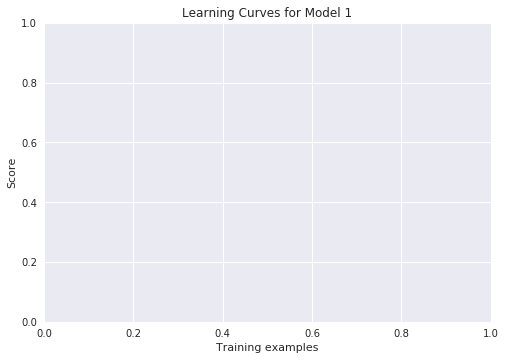

In [10]:
# Learning curves
# Watch out, this takes up a lot of primary memory
from sklearn import cross_validation
from support_functions import plot_learning_curve

# Slices of data for learning curves
train_sizes=np.linspace(0.1, 1.0, 10)
title = "Learning Curves for Model 1"
message = "M1"
# Cross validation scheme with 80-20 splits and 3 iterations per train data size (to evaluate variance)
cv = cross_validation.ShuffleSplit(len(X_rest), n_iter=3,
                                   test_size=0.2, random_state=0)
estimator = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2= 0.067592883332507694, c1= 0.37774963191685329,
    max_iterations=100, 
    all_possible_transitions=False
)
plot_learning_curve(estimator, title, X_rest, y_rest, labels_to_keep, cv=cv, train_sizes=train_sizes, n_jobs=20, message=message)

In [11]:
%%time
# VALIDATION

crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs',
    c2= 0.067592883332507694, c1= 0.37774963191685329,
    max_iterations=500,
    all_possible_transitions=True
)
crf.fit(X_rest, y_rest)
y_pred = crf.predict(X_valid)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=labels_to_keep, digits=3
))

                           precision    recall  f1-score   support

                               0.826     0.865     0.845     23619
                   series      0.906     0.779     0.838       136
               pagination      0.901     0.895     0.898      6651
                foliation      0.938     0.819     0.875       570
                publisher      0.818     0.760     0.788       968
                      ref      0.579     0.324     0.415       476
              cartulation      0.792     0.819     0.805       695
                   column      0.887     0.732     0.802       343
             numbered_ref      0.538     0.484     0.509      1343
              archive_lib      0.866     0.792     0.827      1349
                    title      0.874     0.904     0.889     27880
               attachment      0.639     0.400     0.492      1237
                    filza      0.735     0.403     0.521        62
        archivalreference      0.685     0.710     0.697     

In [12]:
# Train final models for task 1
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2= 0.067592883332507694, c1= 0.37774963191685329,
    max_iterations=500, 
    all_possible_transitions=True
)
crf.fit(d, l)

# save model
from sklearn.externals import joblib
joblib.dump(crf,'models/modelM1_ALL_L.pkl')

['models/modelM1_ALL_L.pkl']

Apply model to new data. This needs to move outside of the notebook.

In [15]:
# load model
from sklearn.externals import joblib
crf1 = joblib.load('models/modelM1_ALL_L.pkl')

In [16]:
def process_document(doc):
    for page in doc["pages"].values():
        if not page["is_annotated"]:
            data_to_tag = [text2features(page["offsets"])]
            page_lab = crf1.predict(data_to_tag)
            assert len(page_lab[0]) == len(page["offsets"])
            page.update({"specific_tags":page_lab[0]})
        else:
            page.update({"specific_tags":text2labelsS(page["offsets"])})
    return doc
            
from multiprocessing import Pool
threads = Pool(45)

In [17]:
# parse all
data2 = list()
for ar in threads.imap_unordered(process_document, data):
    data2.append(ar)

In [18]:
pickle.dump(data2, open("data/test_data.p", "wb"))